# **Metabolic syndrome prediction model training**

## Loading the Data

In [160]:
import pandas as pd

df = pd.read_csv("/content/Metabolic Syndrome.csv")
df

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,0
2397,71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,0
2398,71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,0
2399,71911,27,Male,Married,8200.0,MexAmerican,106.6,31.3,0,4.15,6.2,100,41,124,1


In [161]:
df.columns

Index(['seqn', 'Age', 'Sex', 'Marital', 'Income', 'Race', 'WaistCirc', 'BMI',
       'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL',
       'Triglycerides', 'MetabolicSyndrome'],
      dtype='object')

## Getting rid of irrelevant columns (from UX perspective)
- `seqn` (highly irrelavant)
- `Marital`
- `Income`
- `WaistCirc` (has high correlaction with `BMI`)

In [162]:
df.drop(columns=['Marital', 'Income', 'WaistCirc', 'seqn'], inplace=True)
df.columns

Index(['Age', 'Sex', 'Race', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides', 'MetabolicSyndrome'],
      dtype='object')

## Categorising some features
Features like `UricAcid`, `HDL`, `Triglycerides` and `Blood glucose` needs to be categorised for user experience

In [163]:
import numpy as np

df['UricAcidCategory'] = np.where(
    ((df['Sex'] == 'Male') & (df['UricAcid'] > 7.0)) |
    ((df['Sex'] == 'Female') & (df['UricAcid'] > 6.0)),
    'High',
    'Normal'
)

df['HDLCategory'] = np.where(
    (df['HDL'] >= 60),
    'Normal',
    'Low'
)

df['TrigCategory'] = np.where(
    (df['Triglycerides'] > 150),
    'High',
    'Normal'
)


conditions = [
    df['BloodGlucose'] < 140,
    (df['BloodGlucose'] >= 140) & (df['BloodGlucose'] < 200),
    df['BloodGlucose'] >= 200
]

choices = [
    'Non-Diabetic',
    'Pre-Diabetic',
    'Diabetic'
]

df['BloodSugarCategory'] = np.select(conditions, choices, default='Unknown')

In [164]:
df.drop(columns=['UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'], inplace=True)
df.columns

Index(['Age', 'Sex', 'Race', 'BMI', 'Albuminuria', 'UrAlbCr',
       'MetabolicSyndrome', 'UricAcidCategory', 'HDLCategory', 'TrigCategory',
       'BloodSugarCategory'],
      dtype='object')

## Making `X` (independent features) and `y` (dependent feature)

In [165]:
X = df[['Age', 'Sex', 'Race', 'BMI', 'Albuminuria', 'UrAlbCr',
        'UricAcidCategory', 'HDLCategory', 'TrigCategory',
       'BloodSugarCategory']]
y = df['MetabolicSyndrome']
X, y

(      Age     Sex         Race   BMI  Albuminuria  UrAlbCr UricAcidCategory  \
 0      22    Male        White  23.3            0     3.88           Normal   
 1      44  Female        White  23.2            0     8.55           Normal   
 2      21    Male        Asian  20.1            0     5.07           Normal   
 3      43  Female        Black  33.3            0     5.22           Normal   
 4      51    Male        Asian  20.1            0     8.13           Normal   
 ...   ...     ...          ...   ...          ...      ...              ...   
 2396   48  Female        Other  59.7            0    22.11           Normal   
 2397   30  Female        Asian  18.0            0     2.90             High   
 2398   28    Male  MexAmerican  29.4            0     2.78           Normal   
 2399   27    Male  MexAmerican  31.3            0     4.15           Normal   
 2400   60    Male        White  27.5            0    12.82           Normal   
 
      HDLCategory TrigCategory BloodSu

## spliting the test and train data

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Making the pipeline

In [167]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipe = Pipeline(
    steps=[
        ("impute_median", SimpleImputer(strategy='median')),
        ("scale", StandardScaler())
    ]
)

cat_one_hot_pipe = Pipeline(
    steps=[
        ("oneHot", OneHotEncoder())
    ]
)

In [168]:
X_train.columns

Index(['Age', 'Sex', 'Race', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcidCategory', 'HDLCategory', 'TrigCategory',
       'BloodSugarCategory'],
      dtype='object')

In [169]:
cat_col = []
num_col = []
target = "HeartDisease"

for col in X_train.columns:
    if(col == target):
        continue    # this is target variable
    if(df[col].dtype == 'object'):
        cat_col.append(col)
    else:
        num_col.append(col)


## Making the column transformer
A pipeline that will **scale** the numeric data and **encode** the categorical data

In [170]:
preprocessor = ColumnTransformer([
    ("Numerical", num_pipe, num_col),
    ("Categorical", cat_one_hot_pipe, cat_col)
])

preprocessor

ColumnTransformer(transformers=[('Numerical',
                                 Pipeline(steps=[('impute_median',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['Age', 'BMI', 'Albuminuria', 'UrAlbCr']),
                                ('Categorical',
                                 Pipeline(steps=[('oneHot', OneHotEncoder())]),
                                 ['Sex', 'Race', 'UricAcidCategory',
                                  'HDLCategory', 'TrigCategory',
                                  'BloodSugarCategory'])])

In [171]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 1. Downsampling (Matching the 665 positive cases)
rus = RandomUnderSampler(random_state=42)
X_train_downsampled, y_train_downsampled = rus.fit_resample(X_train, y_train)

# 2. Upsampling (Matching the 1255 negative cases)
# smote = SMOTE(random_state=42)
# X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

# Quick Verification
print(f"Downsampled shape: {y_train_downsampled.value_counts().to_dict()}")
# print(f"Upsampled shape: {y_train_upsampled.value_counts().to_dict()}")

Downsampled shape: {0: 665, 1: 665}


## Trying different algorithms
Also trying each with different combinations of parameters

In [172]:
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb

models_list = {
    "K-Nearest Neighbor": {
        "model": KNeighborsClassifier(),
        "params": {
            "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 15, 25],
            "kneighborsclassifier__weights": ["uniform", "distance"],
            "kneighborsclassifier__metric": ["euclidean", "manhattan", "minkowski"],
            "kneighborsclassifier__p": [1, 2]   # p=1 → manhattan, p=2 → euclidean
        }
    },

    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'randomforestclassifier__n_estimators': [5, 10, 20, 30, 50, 100],
            'randomforestclassifier__max_depth': [2, 5, 7, None],
            'randomforestclassifier__max_samples': [0.5, 0.6, 0.75, 0.9, 1]
        }
    },

    "Adaoost": {
        "model": AdaBoostClassifier(estimator=DecisionTreeClassifier()),
        "params": {
            "adaboostclassifier__n_estimators": [10, 20, 25, 30],
            "adaboostclassifier__learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5],
            "adaboostclassifier__estimator__max_depth": [1, 2, 3],
            "adaboostclassifier__estimator__min_samples_split": [2, 5, 10]
        }
    },

    "LightGBM": {
        "model": lgb.LGBMClassifier(),
        "params": {
            "lgbmclassifier__n_estimators": [50, 100, 200],
            "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1],
            "lgbmclassifier__num_leaves": [15, 31, 63],
            "lgbmclassifier__max_depth": [-1, 5, 10],
            "lgbmclassifier__subsample": [0.6, 0.8, 1.0],
            "lgbmclassifier__colsample_bytree": [0.6, 0.8, 1.0]
        }
    },

    "XGBoost": {
        "model": xgb.XGBClassifier(),
        "params": {
            "xgbclassifier__n_estimators": [50, 100, 200],
            "xgbclassifier__learning_rate": [0.01, 0.05, 0.1],
            "xgbclassifier__max_depth": [3, 5, 7],
            "xgbclassifier__subsample": [0.6, 0.8, 1.0],
            "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0]
        }
    }
}

In [173]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

recall_yes = make_scorer(
    recall_score,
    pos_label=1
)

print("Training with imbalance data: ")

for model_name, config in models_list.items():
    model = config["model"]
    params = config["params"]

    pipe = make_pipeline(preprocessor, model)

    ran_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        scoring=recall_yes,
        cv=4,
        verbose=2,
        n_jobs=-1
    )

    ran_search.fit(X_train, y_train)

    print(f"{model_name}:")
    print(f"Best Score: {ran_search.best_score_}")
    print(f"Best parameters: {ran_search.best_params_}")
    print("------------------\n")

Training with imbalance data: 
Fitting 4 folds for each of 10 candidates, totalling 40 fits
K-Nearest Neighbor:
Best Score: 0.631511074237068
Best parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__p': 1, 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__metric': 'euclidean'}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Random Forest:
Best Score: 0.6480863574056706
Best parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_samples': 0.5, 'randomforestclassifier__max_depth': 7}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Adaoost:
Best Score: 0.691679893225597
Best parameters: {'adaboostclassifier__n_estimators': 30, 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__estimator__min_samples_split': 10, 'adaboostclassifier__estimator__max_depth': 3}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[L

In [174]:
print("Training with downsampled data: ")

for model_name, config in models_list.items():
    model = config["model"]
    params = config["params"]

    pipe = make_pipeline(preprocessor, model)

    ran_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        scoring=recall_yes,
        cv=4,
        verbose=2,
        n_jobs=-1
    )

    ran_search.fit(X_train_downsampled, y_train_downsampled)

    print(f"{model_name}:")
    print(f"Best Score: {ran_search.best_score_}")
    print(f"Best parameters: {ran_search.best_params_}")
    print("------------------\n")

Training with downsampled data: 
Fitting 4 folds for each of 10 candidates, totalling 40 fits
K-Nearest Neighbor:
Best Score: 0.7774601399610418
Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__metric': 'euclidean'}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Random Forest:
Best Score: 0.8045054469374504
Best parameters: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_samples': 0.9, 'randomforestclassifier__max_depth': None}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Adaoost:
Best Score: 0.8857676213837384
Best parameters: {'adaboostclassifier__n_estimators': 25, 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__estimator__min_samples_split': 5, 'adaboostclassifier__estimator__max_depth': 2}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 f

In [182]:
print("Training with upsampled data: ")

for model_name, config in models_list.items():
    model = config["model"]
    params = config["params"]

    pipe = make_pipeline(preprocessor, SMOTE(random_state=42), model)

    ran_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        scoring='recall',
        cv=4,
        verbose=2,
        n_jobs=-1
    )

    ran_search.fit(X_train, y_train)

    print(f"{model_name}:")
    print(f"Best Score: {ran_search.best_score_}")
    print(f"Best parameters: {ran_search.best_params_}")
    print("------------------\n")

Training with upsampled data: 
Fitting 4 folds for each of 10 candidates, totalling 40 fits
K-Nearest Neighbor:
Best Score: 0.787948199985571
Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__metric': 'minkowski'}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Random Forest:
Best Score: 0.7683789048409205
Best parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_samples': 0.6, 'randomforestclassifier__max_depth': 7}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Adaoost:
Best Score: 0.9082136930957362
Best parameters: {'adaboostclassifier__n_estimators': 20, 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__estimator__min_samples_split': 10, 'adaboostclassifier__estimator__max_depth': 2}
------------------

Fitting 4 folds for each of 10 candidates, totalling 40 fits


## we have got good recall in four models
- AdaBoost with upsampled data
```
{'adaboostclassifier__n_estimators': 20,
'adaboostclassifier__learning_rate': 0.01,
'adaboostclassifier__estimator__min_samples_split': 10
'adaboostclassifier__estimator__max_depth': 2}
```
- AdaBoost with downsampled data
```
{'adaboostclassifier__n_estimators': 25,
'adaboostclassifier__learning_rate': 0.01,
'adaboostclassifier__estimator__min_samples_split': 5,
'adaboostclassifier__estimator__max_depth': 2}
```
- LightGBM with downsampled data
```
{'lgbmclassifier__subsample': 0.6,
'lgbmclassifier__num_leaves': 63,
'lgbmclassifier__n_estimators': 50,
'lgbmclassifier__max_depth': 5,
'lgbmclassifier__learning_rate': 0.01,
'lgbmclassifier__colsample_bytree': 1.0}
```
- XGBoost with downsampled data
```
{'xgbclassifier__subsample': 0.8,
'xgbclassifier__n_estimators': 100,
'xgbclassifier__max_depth': 7,
'xgbclassifier__learning_rate': 0.05,
'xgbclassifier__colsample_bytree': 0.6}
```

> We will check for `accuracy` before selecting the final model

In [242]:
models = {
    "Ada_down": {
        "model": AdaBoostClassifier(estimator=DecisionTreeClassifier(min_samples_split=5, max_depth=2), learning_rate=0.01, n_estimators=25),
        "type": "down"
    },

    "Ada_up": {
        "model": AdaBoostClassifier(estimator=DecisionTreeClassifier(min_samples_split=10, max_depth=2), learning_rate=0.01, n_estimators=20),
        "type": "up"
    },

    "lighgbm": {
        "model": lgb.LGBMClassifier(subsample=0.6, num_leaves=63, n_estimators=50, max_depth=5, learning_rate=0.01, colsample_bytree=1.0),
        "type": "down"
    },

    "xgboost": {
        "model": xgb.XGBClassifier(subsample=0.8, n_estimators=100, max_depth=7, learning_rate=0.05, colsample_bytree=0.6),
        "type": "down"
    }
}

results_list = []

for key in models.keys():
    model = models[key]["model"]
    isUp = False if models[key]["type"] == "down" else True

    pipe = make_pipeline(preprocessor, model)
    if(isUp):
        pipe = make_pipeline(preprocessor, SMOTE(random_state=42), model)
        pipe.fit(X_train, y_train)
    else:
        pipe.fit(X_train_downsampled, y_train_downsampled)

    y_pred = pipe.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)
    rec = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)

    # Store in list
    results_list.append({
        "Model": key,
        "Sampling": "Upsampled" if isUp else "Downsampled",
        "Accuracy": acc,
        "Recall": rec,
        "Diff (Acc-Rec)": acc - rec # Helpful to see the gap
    })

# Create the DataFrame
results_df = pd.DataFrame(results_list).sort_values(by="Recall", ascending=False)

[LightGBM] [Info] Number of positive: 665, number of negative: 665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 1330, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [243]:
results_df

,Model,Sampling,Accuracy,Recall,Diff (Acc-Rec)
0,Ada_down,Downsampled,0.700624,0.904459,-0.203835
1,Ada_up,Upsampled,0.704782,0.904459,-0.199677
2,lighgbm,Downsampled,0.785863,0.783439,0.002423
3,xgboost,Downsampled,0.783784,0.764331,0.019453


In [244]:
pipe = make_pipeline(preprocessor, SMOTE(random_state=42), AdaBoostClassifier(estimator=DecisionTreeClassifier(min_samples_split=10, max_depth=2), learning_rate=0.01, n_estimators=20))

In [245]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'BMI', 'Albuminuria',
                                                   'UrAlbCr']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Race',
                                                   'UricAcidCategory',
                                                   'HDLCategory',
                                                   'TrigCategory',
                                                   'BloodSugarCategory'])])),
                ('smote', SMOTE(random_state=42)),
                ('adaboostclassifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                     min_samples_split=10),
                                    learning_rate=0.01, n_estimators=20))])

In [246]:
y_pred = pipe.predict(X_test)

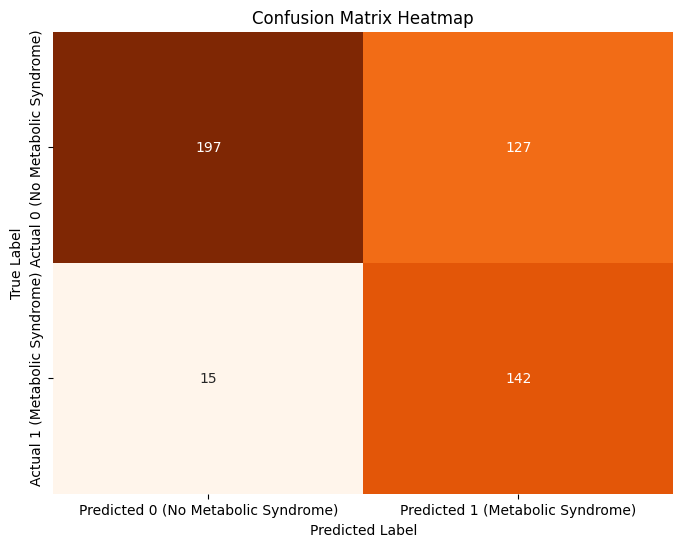

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_pred=y_pred, y_true=y_test), fmt='d', cmap='Oranges', annot=True, cbar=False,
            xticklabels=['Predicted 0 (No Metabolic Syndrome)', 'Predicted 1 (Metabolic Syndrome)'],
            yticklabels=['Actual 0 (No Metabolic Syndrome)', 'Actual 1 (Metabolic Syndrome)'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()